In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.fftpack import dct

def dct_heatmap(image_path):
    image = cv2.imread(image_path)
    
    if image is None:
        print("Error: Unable to load image from the path provided.")
        return
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Applying 2D DCT to images
    dct_transformed = dct(dct(gray_image.T, norm='ortho').T, norm='ortho')
    
    # Log scale the DCT coefficients and avoiding log(0) to avoid 1
    dct_log = np.log(np.abs(dct_transformed) + 1)
    
    # Normalize the log-scaled DCT values to a range of 0 to 1
    dct_normalized = cv2.normalize(dct_log, None, 0, 1, cv2.NORM_MINMAX)
    
    # Plot the DCT values as a heatmap
    plt.imshow(dct_normalized, interpolation='nearest')
    plt.colorbar()
    plt.title("DCT Heatmap")
    plt.show()



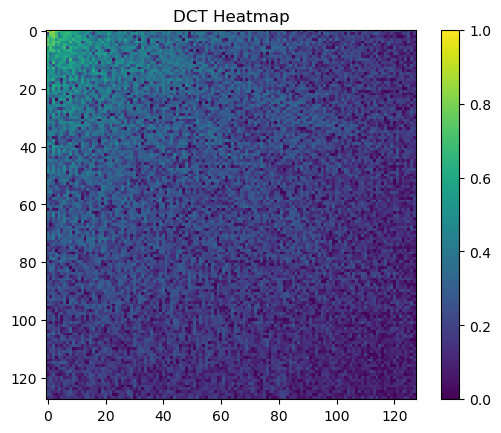

In [2]:
image_path = "C:/Users/uzzwa/Downloads/wec-intelligence-sig-2024-recruitment-task-cv/train_images/train_images/real_train/00901.png"  # Replace with your image path
dct_heatmap(image_path)

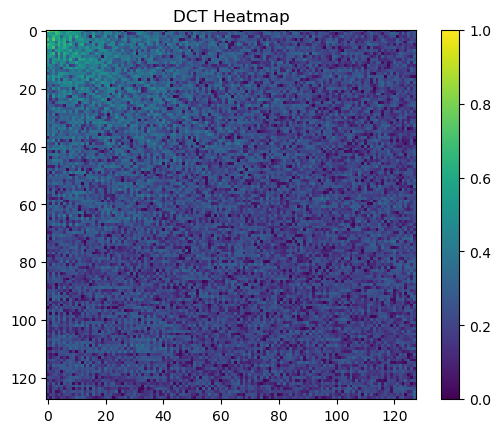

In [3]:
image_path = "C:/Users/uzzwa/Downloads/wec-intelligence-sig-2024-recruitment-task-cv/train_images/train_images/fake_train/image_12.png"  # Replace with your image path
dct_heatmap(image_path)

Very Clear Observation like the paper suggested that the images generated by GANs are not converging to zero(purple colour) on the lower right corner while the real images become dark purple. First graph is that of a real image and the second is that of a fake generated image.

# Creating a CNN model based on paper

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

def custom_cnn_model(input_shape):
    model = models.Sequential()
    
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(3, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
    model.add(layers.AveragePooling2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(layers.AveragePooling2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(1, activation='sigmoid'))  # 5 classes, softmax for classification
    
    adam_optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.0001,  
        beta_1=0.9,           
        beta_2=0.999,         
        epsilon=1e-7          
    )
    
    #Above params are specified by the paper
    
    model.compile(optimizer=adam_optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [6]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

In [7]:
#A function to convert all images in the folder into a 2D DCT forms with log normalized values in the range 0 to 1,
#same as the first function
def process(image_path):
    
    image = cv2.imread(image_path)
    
    if image is None:
        print("Error: Unable to load image from the path provided.")
        return
#Just to make sure all images are coloured
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    dct_transformed = dct(dct(gray_image.T, norm='ortho').T, norm='ortho')
    dct_log = np.log(np.abs(dct_transformed) + 1)
    image = cv2.normalize(dct_log, None, 0, 1, cv2.NORM_MINMAX)
    
    image_rgb = cv2.cvtColor(np.float32(image), cv2.COLOR_GRAY2RGB)
    
    return image_rgb


I have tried multiple methods where the processed gray scale images are stacked into 3 channels then inputted, converting them into RGB again to input into model etc
Almost no change in behaviour at all, so went ahead with RGB conversion

In [12]:
def load_data(folder_real, folder_fake):
    data = []
    labels = []
    file_paths = [] 
    
    '''I wasn't planning on saving file paths as well but the problem is that when I trained the model for the first time
     in the confusion matrix it was giving wrong output for one particular image. Since I used Tensorflow libraries to 
     randomly pick the images to put into train, test and validate folders there was no way of tracing a particular image
      in X_test which is already processed btw to the original image to figure out if the image is faulty or not ''' 
    
    # Images in real images folder
    for img_name in os.listdir(folder_real):
        img_path = os.path.join(folder_real, img_name)
        img = process(img_path)  # Preprocess image
        data.append(img)
        labels.append(0)  # Zero for Real images
        file_paths.append(img_path)
    
    # Images in fake images folder
    for img_name in os.listdir(folder_fake):
        img_path = os.path.join(folder_fake, img_name)
        img = process(img_path)  # Preprocess image
        data.append(img)
        labels.append(1)  # One for fake images
        file_paths.append(img_path)
    #Converting all into numpy arrays
    data = np.array(data)
    labels = np.array(labels)
    file_paths = np.array(file_paths)
    
    return data, labels, file_paths


In [13]:
folder_real = "C:/Users/uzzwa/Downloads/wec-intelligence-sig-2024-recruitment-task-cv/train_images/train_images/real_train"
folder_fake = "C:/Users/uzzwa/Downloads/wec-intelligence-sig-2024-recruitment-task-cv/train_images/train_images/fake_train"
data, labels, file_paths = load_data(folder_real, folder_fake)

# Splitting (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp, train_paths, temp_paths = train_test_split(
    data, labels, file_paths, test_size=0.4, random_state=42
)
X_val, X_test, y_val, y_test, val_paths, test_paths = train_test_split(
    X_temp, y_temp, temp_paths, test_size=0.5, random_state=42
)

print("Train set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)

Train set: (960, 128, 128, 3)
Validation set: (320, 128, 128, 3)
Test set: (320, 128, 128, 3)


In [20]:
input_shape=X_train.shape[1:4]
input_shape

(128, 128, 3)

In [29]:
model = custom_cnn_model(input_shape)

history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.5107 - loss: 0.6867 - val_accuracy: 0.5031 - val_loss: 0.6739
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.5968 - loss: 0.6665 - val_accuracy: 0.7875 - val_loss: 0.6314
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8370 - loss: 0.6106 - val_accuracy: 0.9375 - val_loss: 0.5165
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.9691 - loss: 0.4699 - val_accuracy: 0.9688 - val_loss: 0.3203
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.9804 - loss: 0.2742 - val_accuracy: 0.9750 - val_loss: 0.1621
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9806 - loss: 0.1326 - val_accuracy: 0.9844 - val_loss: 0.0973
Epoch 7/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9908 - loss: 0.0801 - val_accuracy: 0.9875 - val_loss: 0.0696
Epoch 8/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9899 - loss: 0.0566 - val_accuracy: 0.9781 -

In [30]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9958 - loss: 0.0154
Test Accuracy: 0.9937499761581421


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


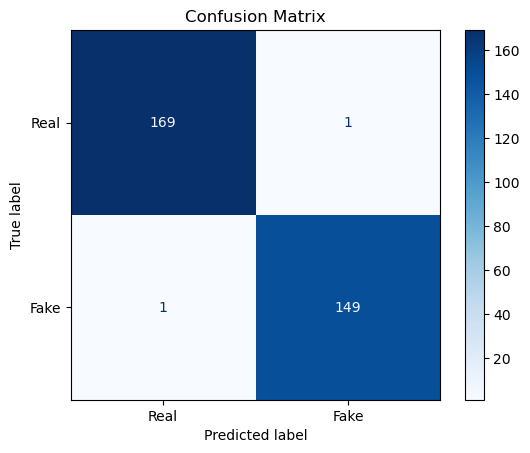

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Predictions on the X_test data
y_pred_prob = model.predict(X_test)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

misclassified_indices = np.where(y_pred != y_test)[0]

#plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [35]:
def find_misclassified(y_pred, y_test):
    misclassified_indices = []

    # Iterating through both arrays to find the index
    for i in range(len(y_pred)):
        if y_pred[i] != y_test[i]:
            misclassified_indices.append(i)
    return misclassified_indices


In [36]:
misclassified_indices = find_misclassified(y_pred, y_test)

print(f"Number of misclassified examples: {len(misclassified_indices)}")

for idx in misclassified_indices:
    print(f"Misclassified at index: {idx}, True label: {y_test[idx]}, Predicted label: {y_pred[idx]}")

Number of misclassified examples: 2
Misclassified at index: 163, True label: 1, Predicted label: [0]
Misclassified at index: 188, True label: 0, Predicted label: [1]


In [37]:
i = 163
print(f"Test image index {i} is from the original file: {test_paths[i]}")
i = 188 
print(f"Test image index {i} is from the original file: {test_paths[i]}")

Test image index 163 is from the original file: C:/Users/uzzwa/Downloads/wec-intelligence-sig-2024-recruitment-task-cv/train_images/train_images/fake_train\image_444.png
Test image index 188 is from the original file: C:/Users/uzzwa/Downloads/wec-intelligence-sig-2024-recruitment-task-cv/train_images/train_images/real_train\00839.png


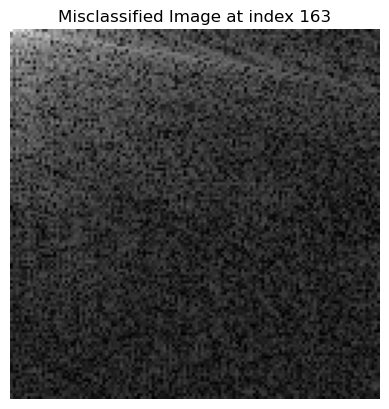

In [38]:
#Displaying the misclassified images
idx = misclassified_indices[0]

# Display the image corresponding to the misclassified index
plt.imshow(X_test[idx].squeeze(), cmap='gray')
plt.title(f"Misclassified Image at index {idx}")
plt.axis('off')
plt.show()

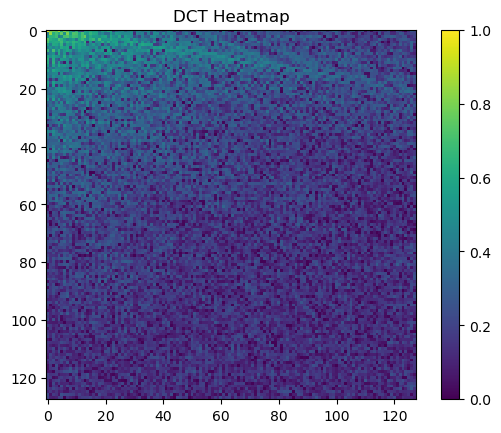

In [40]:
#dct_heat map of the above image
image_path="C:/Users/uzzwa/Downloads/wec-intelligence-sig-2024-recruitment-task-cv/train_images/train_images/fake_train/image_444.png"
dct_heatmap(image_path)

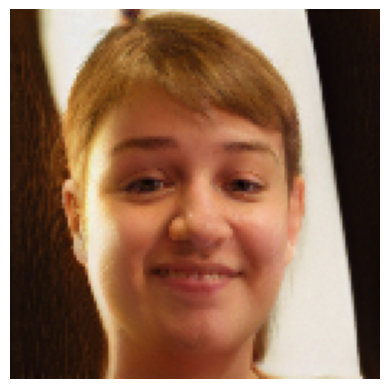

In [41]:
from PIL import Image

image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

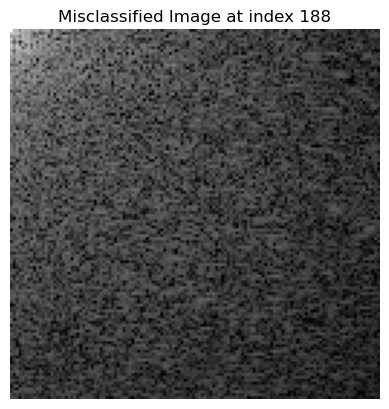

In [42]:
idx = misclassified_indices[1]

# Display the image corresponding to the misclassified index
plt.imshow(X_test[idx].squeeze(), cmap='gray')
plt.title(f"Misclassified Image at index {idx}")
plt.axis('off')
plt.show()

In [43]:
image_path="C:/Users/uzzwa/Downloads/wec-intelligence-sig-2024-recruitment-task-cv/train_images/train_images/real_train/00839.png"

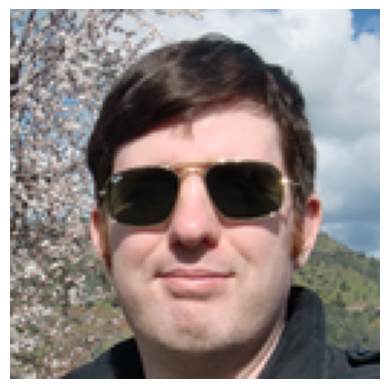

In [44]:
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

Again nothing out of the ordinary so maybe the model is not good enough, maybe training with the entire training dataset rather than splitting it helps since I only considered 60% of it

## Using Saliency Maps to confirm if the model is actually looking at bottom right for classification

In [45]:
def generate_saliency_map(model, processed_image, class_index=0):
    processed_image = tf.convert_to_tensor(processed_image)
    with tf.GradientTape() as tape:
        tape.watch(processed_image)
        predictions = model(processed_image)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, processed_image)

    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]

    return saliency.numpy()

def visualize_saliency_map(image, saliency_map):
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image[0])
    plt.title('Original Image')
    
    plt.subplot(1, 2, 2)
    plt.imshow(saliency_map, cmap='hot')
    plt.title('Saliency Map')
    
    plt.show()

In [46]:
path = "C:/Users/uzzwa/Downloads/wec-intelligence-sig-2024-recruitment-task-cv/train_images/train_images/fake_train/image_444.png"
image = process(path)
image = np.expand_dims(image, axis=0)

In [47]:
model.predict(image)
#Predicting as a real image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


array([[0.24488968]], dtype=float32)

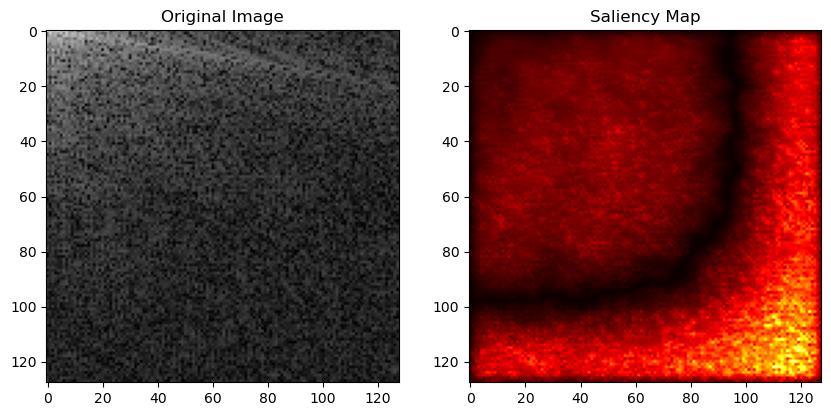

In [48]:
saliency_map = generate_saliency_map(model,image)
visualize_saliency_map(image, saliency_map)

As it can be seen the model has heavily considered the bottom right corner part for prediction so it is in the right track

In [49]:
#Making the CSV File, extracting id from the image names
def get_image_id(filename):
    return filename.split('_')[-1].split('.')[0]

In [50]:
s = get_image_id("test_image_12")
s

'12'

In [51]:
test_folder = "C:/Users/uzzwa/Downloads/wec-intelligence-sig-2024-recruitment-task-cv/test_images/test_images"

In [52]:
def load_test_data(folder_a):
    data = []
    sn = []
    
    for img_name in os.listdir(folder_a):
        image_id = get_image_id(img_name)
        img_path = os.path.join(folder_a, img_name)
        img = process(img_path)  # Preprocess image
        data.append(img)
        sn.append(image_id) 
    
    data = np.array(data)
    sn = np.array(sn)
    
    return data, sn

data, sn = load_test_data(test_folder)

In [53]:
sn

array(['1', '10', '100', '101', '102', '103', '104', '105', '106', '107',
       '108', '109', '11', '110', '111', '112', '113', '114', '115',
       '116', '117', '118', '119', '12', '120', '121', '122', '123',
       '124', '125', '126', '127', '128', '129', '13', '130', '131',
       '132', '133', '134', '135', '136', '137', '138', '139', '14',
       '140', '141', '142', '143', '144', '145', '146', '147', '148',
       '149', '15', '150', '151', '152', '153', '154', '155', '156',
       '157', '158', '159', '16', '160', '161', '162', '163', '164',
       '165', '166', '167', '168', '169', '17', '170', '171', '172',
       '173', '174', '175', '176', '177', '178', '179', '18', '180',
       '181', '182', '183', '184', '185', '186', '187', '188', '189',
       '19', '190', '191', '192', '193', '194', '195', '196', '197',
       '198', '199', '2', '20', '200', '201', '202', '203', '204', '205',
       '206', '207', '208', '209', '21', '210', '211', '212', '213',
       '214', '215', '

# Making another model

In [58]:
import tensorflow as tf
from tensorflow.keras import layers, models

def custom_cnn_model2(input_shape):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(64, activation='relu'))

    model.add(layers.Dense(1, activation='sigmoid')) 

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

input_shape = (128, 128, 3)
model = custom_cnn_model(input_shape)
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 128, 128, 3)         │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 128, 128, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_8                  │ (None, 64, 64, 8)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 64, 64, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_9                  │ (None, 32, 32, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │          32,769 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,885 (151.89 KB)

 Trainable params: 38,885 (151.89 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
model = custom_cnn_model2(input_shape)

history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val))

C:\Users\uzzwa\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 612ms/step - accuracy: 0.4859 - loss: 0.7325 - val_accuracy: 0.5031 - val_loss: 0.6405
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 613ms/step - accuracy: 0.6327 - loss: 0.5824 - val_accuracy: 0.9500 - val_loss: 0.4259
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 541ms/step - accuracy: 0.8886 - loss: 0.4317 - val_accuracy: 0.9500 - val_loss: 0.3864
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 533ms/step - accuracy: 0.9629 - loss: 0.3660 - val_accuracy: 0.9187 - val_loss: 0.3829
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 627ms/step - accuracy: 0.9645 - loss: 0.3679 - val_accuracy: 0.9219 - val_loss: 0.3696
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 607ms/step - accuracy: 0.9560 - loss: 0.3524 - val_accuracy: 0.9906 - val_loss: 0.3625
Epoch 7/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 600ms/step - accuracy: 0.9824 - loss: 0.3493 - val_accuracy: 0.9375 - val_loss: 0.3763
Epoch 8/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 590ms/step - accuracy: 0.9585 - loss: 0.3577 - val_accu

In [60]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 0.2507
Test Accuracy: 1.0


This model performed better than the old one with no wrong predictions in the test cases at all

In [61]:
#Just checking for one of images which was classified incorrectly by previous model
path = "C:/Users/uzzwa/Downloads/wec-intelligence-sig-2024-recruitment-task-cv/train_images/train_images/fake_train/image_444.png"
image = process(path)
image = np.expand_dims(image, axis=0)

In [62]:
model.predict(image)
#Predicted fake correctly

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


array([[0.6162478]], dtype=float32)

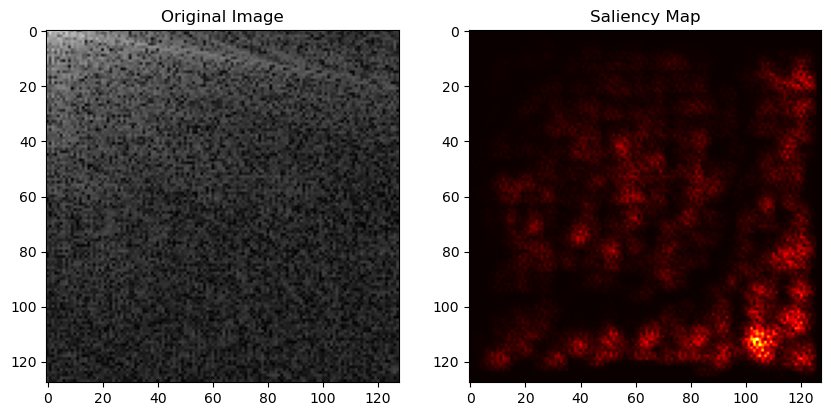

In [63]:
#Saliency map to check for this new model
saliency_map = generate_saliency_map(model,image)
visualize_saliency_map(image, saliency_map)

It is considering the bottom right corner for predictions so this model is also on the right track